This is a notebook for training a transformer based classifier that predicts the party affiliations of the speakers of speeches held in the Finnish Parliament.

This is based largely on https://github.com/TurkuNLP/Deep_Learning_in_LangTech_course/blob/master/hf_trainer_bert.ipynb

### Setup

In [1]:
# Import comet_ml for logging and plotting
# comet_ml must be imported before other ML frameworks for it to work properly

import comet_ml

comet_ml.init(project_name = 'semparl-classifier')

COMET INFO: Comet API key is valid


In [1]:
# Import required modules
from pprint import PrettyPrinter
pprint = PrettyPrinter(compact=True).pprint

from datasets import load_dataset
import transformers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Setup file paths

xp_name = 'jupyter_model4' # Name of experiment that will be used to identify saved files

train_data = '../data/parl_speeches_2000-2021_threeparties_train.csv'
validation_data = '../data/parl_speeches_2000-2021_threeparties_validation.csv'
test_data = '../data/parl_speeches_2000-2021_threeparties_test.csv'
cache_dir = '../hf_cache' #hf cache can get bloated with multiple runs so save to disk with enough storage
output_dir = f'../results/models/{xp_name}' # Where the checkpoints are saved

### Data preprocess

In [3]:
# Load in train and test data
print('Loading dataset...')

# Speeches between 2000 and 2001 from the three parties that held the bulk of speehces: KOK, SD, KESK
# The data has been shuffled, i.e., its not in chronological order

dataset = load_dataset('csv', data_files = {'train': train_data,
                                            'validation' : validation_data,
                                            'test': test_data},
                      cache_dir = cache_dir
                      ) 

# Shuffle the dataset for good measure
dataset=dataset.shuffle()

Loading dataset...


Using custom data configuration default-70acfe5f3a43cb53
Reusing dataset csv (../hf_cache/csv/default-70acfe5f3a43cb53/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Let's see how the labels are distributed in the data
train_data = pd.read_csv(train_data)
validation_data = pd.read_csv(validation_data)
test_data = pd.read_csv(test_data)
print('Label distribution')
pprint(train_data['label'].value_counts(normalize = True))
pprint(validation_data['label'].value_counts(normalize = True))
pprint(test_data['label'].value_counts(normalize = True))

Label distribution
2    0.344965
0    0.328572
1    0.326463
Name: label, dtype: float64
2    0.338790
0    0.335491
1    0.325719
Name: label, dtype: float64
2    0.341488
0    0.334080
1    0.324432
Name: label, dtype: float64


Text(0, 0.5, 'Number of speeches')

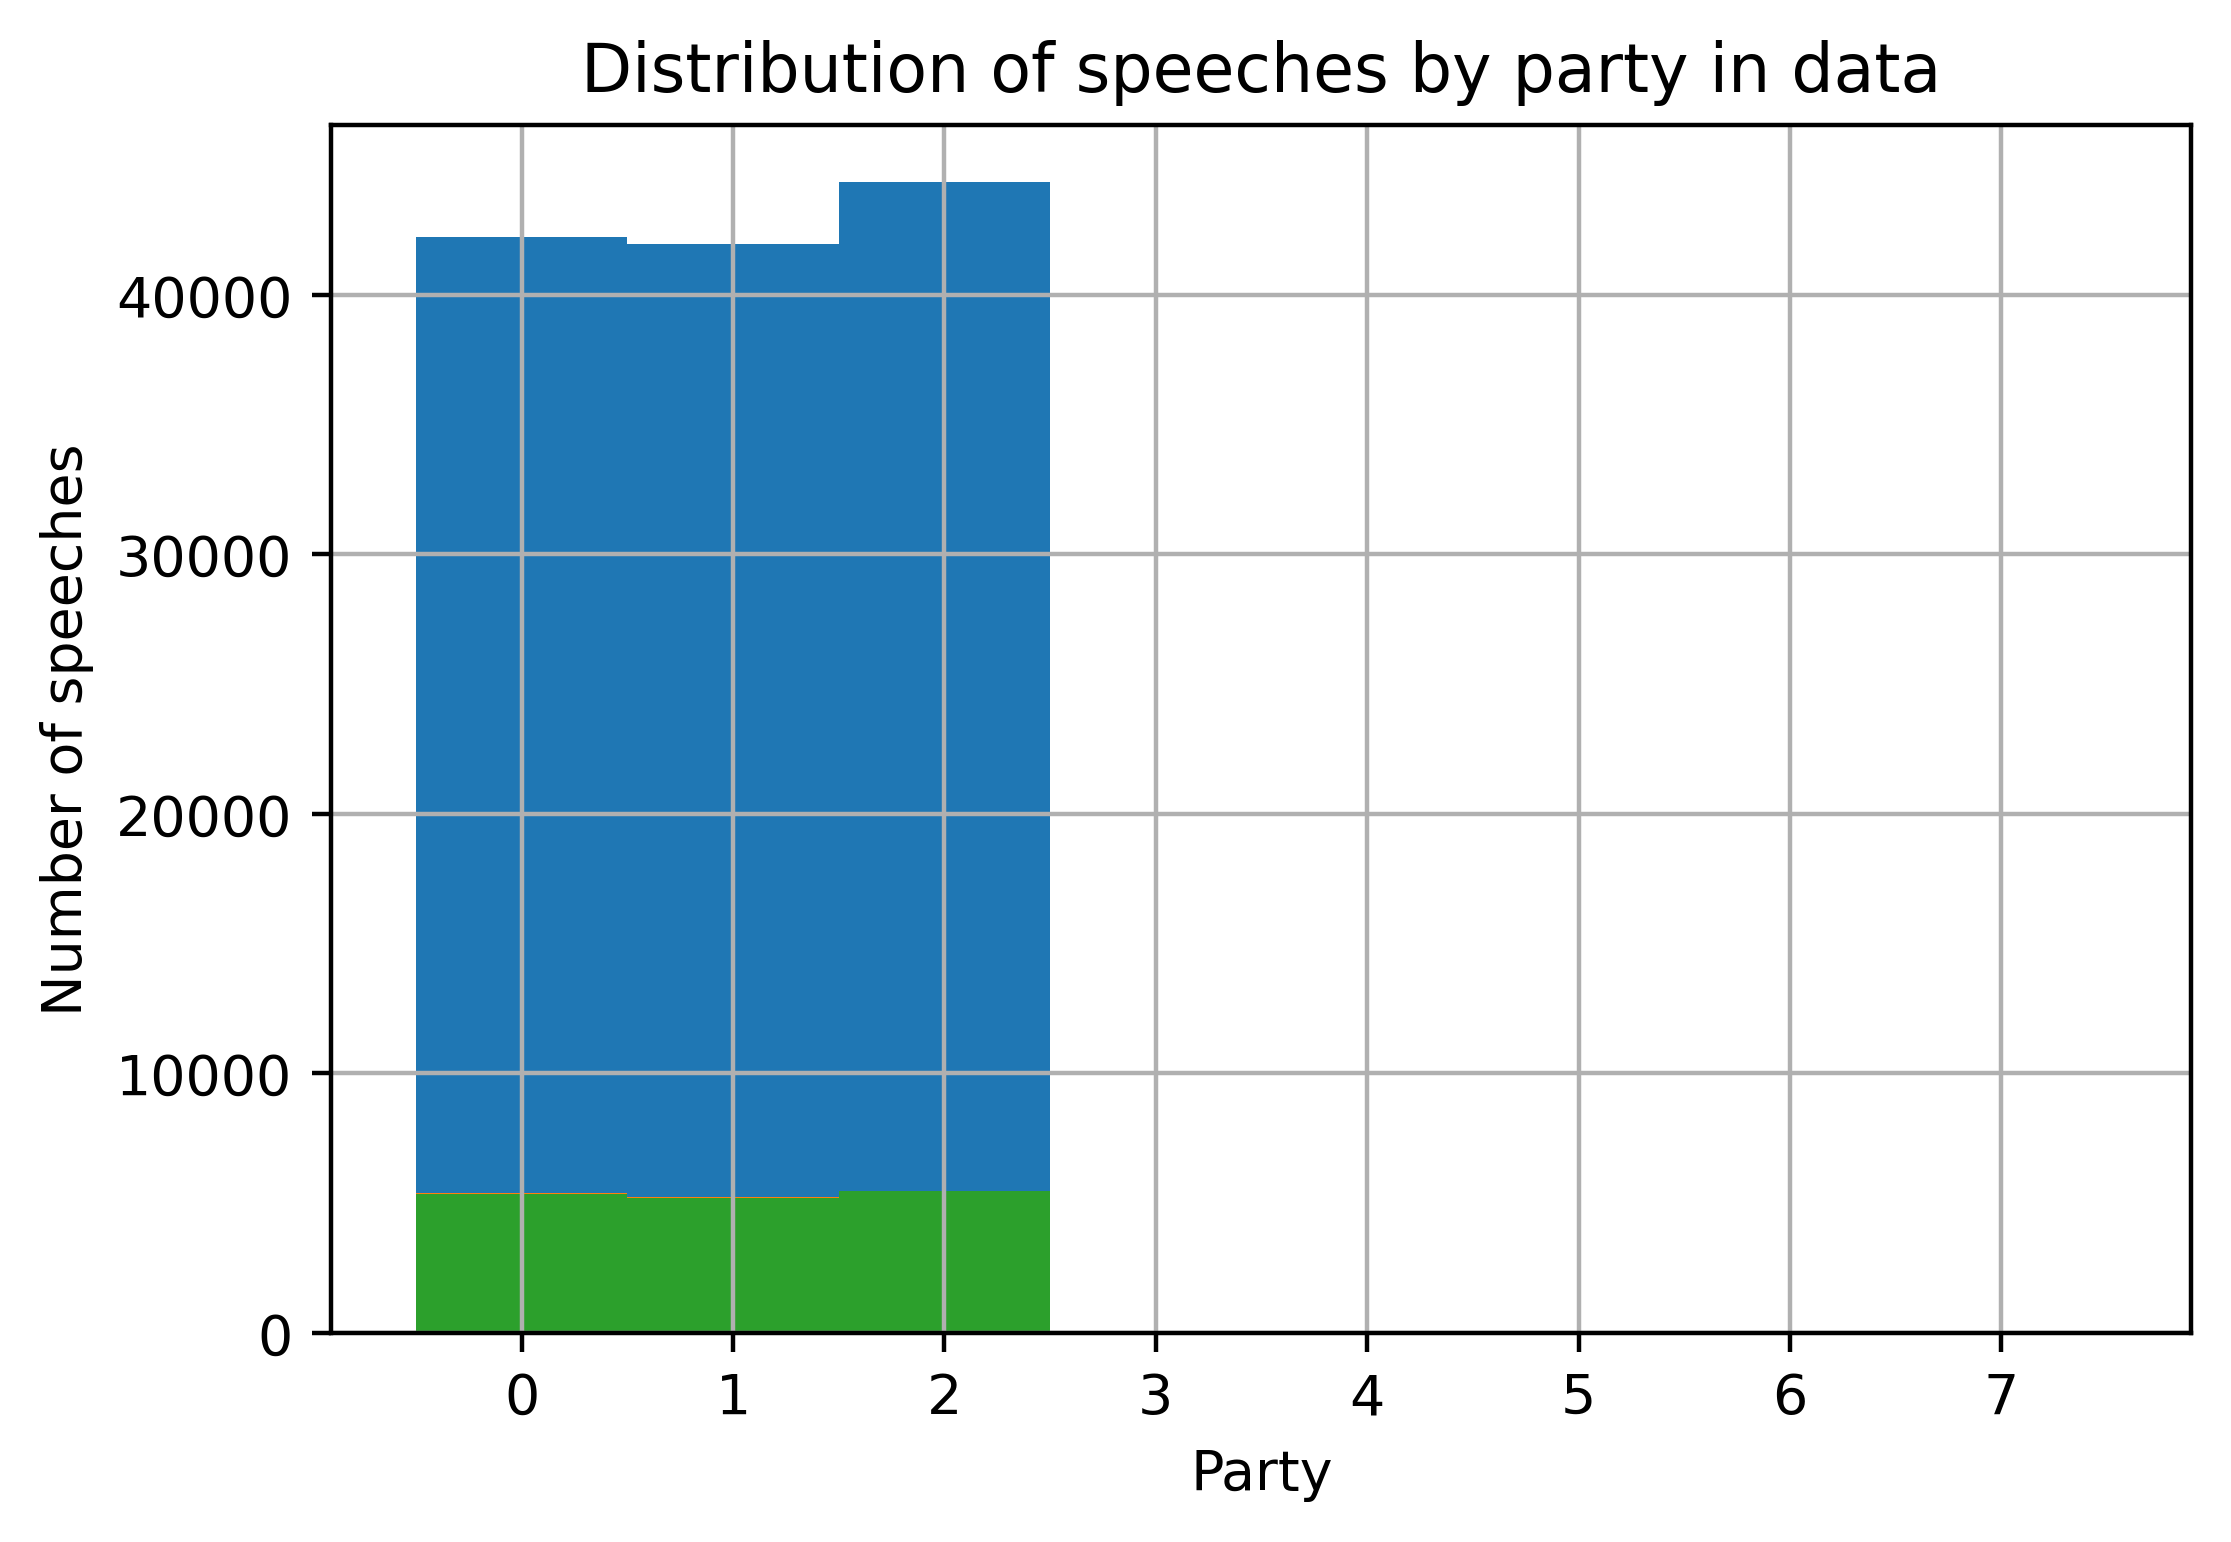

In [5]:
# Let's see how it looks in a histogram

party_bins = np.array(range(0,9)) - 0.5

import matplotlib as mpl # Adds plotting functionality
mpl.rcParams['figure.dpi'] = 400 # This gives high resolution figures


train_data['label'].hist(bins = party_bins)

validation_data['label'].hist(bins = party_bins)

test_data['label'].hist(bins = party_bins)
plt.title('Distribution of speeches by party in data')
plt.xlabel('Party')
plt.ylabel('Number of speeches')

In [6]:
# Let's see what the data looks like
print('Here is the dataset:')
pprint(dataset)
print('This is an example sentence from the dataset:')
pprint(dataset['train'][0])

Here is the dataset:
{'test': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year'],
    num_rows: 16065
}),
 'train': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year'],
    num_rows: 128523
}),
 'validation': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year'],
    num_rows: 16066
})}
This is an example sentence from the dataset:
{'id': 27790,
 'label': 2,
 'speaker': 'Matti_Vanhanen',
 'text': 'Arvoisa puhemies! Komissaarikysymyksen osalta Italia ei tehnyt uutta '
         'ehdotusta. Kysymys on myös siltä osin avoinna. Meillä on edelleen '
         'entinen tavoite olemassa. Työeläkejärjestelmään aikanaan '
         'liittymissopimuksessa saamastamme poikkeuksesta pidetään kiinni. '
         'Emme ryhdy käymään jäsenyysneuvotteluja tämän asian osalta '
         'uudelleen, eli tässä tavoite on saavutettu. Meillä on monta muutakin '
         'keskeistä tavoitetta. Myös kauppapolitiikkaan liittyvät kysymykset '
         'ovat täysin auki. I

In [8]:
# Get the number of labels, which is required for the model
train_labels = dataset['train']['label']
test_labels = dataset['test']['label']
label_ints = sorted(list(set(train_labels + test_labels)))
num_labels = len(set(train_labels + test_labels))

# Dict for converting label numbers back into party names
id2label = {0 : 'SD', 1 : 'KOK', 2 : 'KESK', 3 : 'VIHR', 4 : 'VAS', 5 : 'PS', 6 : 'R', 7 : 'KD'}

# Get the labels that are actually in the current dataset in correct order
id2label_in_data = {}
for key, value in id2label.items():
    if key in label_ints:
        id2label_in_data[key] = value

label2id_in_data = {}
for key, value in id2label_in_data.items():
    label2id_in_data[value] = key

print('Here are the labels:')
print(id2label_in_data)

Here are the labels:
{0: 'SD', 1: 'KOK', 2: 'KESK'}


### Tokenization

In [9]:
# Initialise model and tokenizer
model_name = 'TurkuNLP/bert-base-finnish-cased-v1'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [10]:
# Define a simple function that applies the tokenizer
# Maximum length of BERT models is 512 due to the position embeddings
def tokenize(example):
    return tokenizer(
        example['text'],
        max_length=512,
        truncation=True
    )
    
# Apply the tokenizer to the whole dataset using .map()
# Batched means that tokenization is done in batches, and hence, faster
print('Tokenizing...')
dataset = dataset.map(tokenize, batched=True)

Tokenizing...


  0%|          | 0/129 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

In [11]:
# Print test sample of tokens
example = dataset['train'][0]['text']
print('This is an example sentence tokenized:')
tokenized = tokenizer(example)
pprint(tokenized)
print('Tokens:')
tokens = tokenizer.tokenize(example)
pprint(tokens)

This is an example sentence tokenized:
{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1],
 'input_ids': [102, 42525, 17397, 380, 13572, 17274, 8582, 953, 3476, 11603,
               193, 2128, 2207, 24276, 111, 9860, 145, 346, 3170, 4407, 15184,
               111, 2604, 145, 1469, 5263, 7557, 2137, 111, 2563, 21487, 17536,
               6228, 39988, 18170, 875, 37535, 403, 3459, 1236, 3914, 1749, 111,
               6787, 18530, 7287, 15051, 13524, 171, 1035, 1458, 3476, 2762,
               119, 802, 1051, 7557, 145, 19528, 111, 2604, 145

In [12]:
print('Here is the dataset after tokenization:')
pprint(dataset)

Here is the dataset after tokenization:
{'test': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16065
}),
 'train': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 128523
}),
 'validation': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 16066
})}


In [13]:
# remove speeches that are 12 tokens long or shorter
too_short = dataset.filter(lambda x: len(x['input_ids']) <= 12)
dataset = dataset.filter(lambda x: len(x['input_ids']) > 12)

  0%|          | 0/129 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/129 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/17 [00:00<?, ?ba/s]

In [14]:
pprint(dataset)
pprint(too_short)

{'test': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 15823
}),
 'train': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 126602
}),
 'validation': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 15841
})}
{'test': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 242
}),
 'train': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1921
}),
 'validation': Dataset({
    features: ['id', 'text', 'label', 'speaker', 'year', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 225
})}


In [22]:
too_short['train'].to_csv("../results/too_short/parl_speeches_2000-2021_threeparties_train_too_short.csv", index=False)
too_short['validation'].to_csv("../results/too_short/parl_speeches_2000-2021_threeparties_validation_too_short.csv", index=False)
too_short['test'].to_csv("../results/too_short/parl_speeches_2000-2021_threeparties_test_too_short.csv", index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

32699

### Training

In [13]:
# Initialise model for sequence classification
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                        num_labels=num_labels,
                                                                        id2label = id2label_in_data,
                                                                        label2id = label2id_in_data)

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

In [14]:
# Set training hyperparameters
trainer_args = transformers.TrainingArguments(
    output_dir = output_dir,
    save_total_limit = 1, # Only keep the best model in the end
    save_strategy = 'steps',
    evaluation_strategy = 'steps',
    logging_strategy= 'steps',
    load_best_model_at_end = True,
    eval_steps = 100,
    logging_steps = 100,
    learning_rate = 0.00001,
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    max_steps = 500,
    label_smoothing_factor = 0.1
)

In [15]:
# Function for computing accuracy and F score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


def get_example(index):
    return dataset['validation'][index]['text'] # Returns text from validation data at index 'index' to show in confusion matrix


def compute_metrics(pred):
    experiment = comet_ml.get_global_experiment() #Get access to the current experiment created in another part of the code

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average = 'macro'
    )
    acc = accuracy_score(labels, preds)

    if experiment:
        step = int(experiment.curr_step) if experiment.curr_step is not None else 0
        experiment.set_step(step)
        experiment.log_confusion_matrix(
            y_true = labels,
            y_predicted = preds,
            file_name = f'confusion-matrix-step-{step}.json',
            labels = list(id2label_in_data.values()),
            index_to_example_function = get_example,
        )

    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [16]:
# Data collator pads the input to be of uniform size
data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience = 5)

In [17]:
# Print a sample of test and validation labels to see that they are not ordered
print('Sample of test and validation labels:')
print(dataset['validation']['label'][:30])
print(dataset['test']['label'][:30])

Sample of test and validation labels:
[2, 2, 2, 0, 1, 1, 0, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 1, 1, 0, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0]
[2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0, 1, 1, 2, 1, 0, 2, 0, 0, 2, 2]


In [18]:
# Train model using arguments defined above

%env COMET_MODE = ONLINE
%env COMET_LOG_ASSETS = TRUE

trainer = None
trainer = transformers.Trainer(
    model = model,
    args = trainer_args,
    train_dataset = dataset['train'],
    eval_dataset = dataset['validation'],
    compute_metrics = compute_metrics,
    data_collator = data_collator,
    tokenizer = tokenizer,
    callbacks = [early_stopping]
)

trainer.train()

env: COMET_MODE=ONLINE
env: COMET_LOG_ASSETS=TRUE


max_steps is given, it will override any value given in num_train_epochs
The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, speaker, year, text. If id, speaker, year, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/scratch/project_2006385/otto/venv/lib64/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 136097
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 500
COMET WARNING: As you are running in a Jupyter

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,1.105000,1.090277,0.387116,0.320789,0.432756,0.384830
200,1.082300,1.055894,0.458473,0.450859,0.458521,0.457692
300,1.063500,1.050422,0.462294,0.459912,0.476551,0.462918
400,1.043600,1.038043,0.480985,0.481304,0.482597,0.480948
500,1.034300,1.037241,0.481338,0.472846,0.482027,0.480341


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, speaker, year, text. If id, speaker, year, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17013
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, speaker, year, text. If id, speaker, year, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17013
  Batch size = 32
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, speaker, year, text. If id, speaker, year, text are not expected by `BertForSequenceClassification.forward`,  y

COMET INFO:     args/hub_model_id                       : None
COMET INFO:     args/hub_strategy                       : HubStrategy.EVERY_SAVE
COMET INFO:     args/hub_token                          : None
COMET INFO:     args/ignore_data_skip                   : False
COMET INFO:     args/label_names                        : None
COMET INFO:     args/label_smoothing_factor             : 0.1
COMET INFO:     args/learning_rate                      : 1e-05
COMET INFO:     args/length_column_name                 : length
COMET INFO:     args/load_best_model_at_end             : True
COMET INFO:     args/local_process_index                : 0
COMET INFO:     args/local_rank                         : -1
COMET INFO:     args/log_level                          : -1
COMET INFO:     args/log_level_replica                  : -1
COMET INFO:     args/log_on_each_node                   : True
COMET INFO:     args/logging_dir                        : ../results/models/jupyter_model3/runs/Sep26_11-3

COMET INFO:     config/tie_encoder_decoder              : False
COMET INFO:     config/tie_word_embeddings              : True
COMET INFO:     config/tokenizer_class                  : None
COMET INFO:     config/top_k                            : 50
COMET INFO:     config/top_p                            : 1.0
COMET INFO:     config/torch_dtype                      : None
COMET INFO:     config/torchscript                      : False
COMET INFO:     config/transformers_version             : None
COMET INFO:     config/type_vocab_size                  : 2
COMET INFO:     config/typical_p                        : 1.0
COMET INFO:     config/use_bfloat16                     : False
COMET INFO:     config/use_cache                        : True
COMET INFO:     config/use_return_dict                  : True
COMET INFO:     config/vocab_size                       : 50105
COMET INFO:   Uploads:
COMET INFO:     asset                    : 1 (1.16 MB)
COMET INFO:     confusion-matrix         : 

TrainOutput(global_step=500, training_loss=1.0657539978027344, metrics={'train_runtime': 1660.1528, 'train_samples_per_second': 9.638, 'train_steps_per_second': 0.301, 'total_flos': 4209814683648000.0, 'train_loss': 1.0657539978027344, 'epoch': 0.12})

### Evaluation

In [19]:
 # Results saved to file for later inspection
def evaluate(xp_name):
    eval_results = trainer.evaluate(dataset["test"])
    with open(f'{output_dir}/evaluation_{xp_name}.txt', 'w') as f:
        f.write('Accuracy: ')
        f.write(f'{eval_results["eval_accuracy"]}\n')
        f.write('F1: ')
        f.write(f'{eval_results["eval_f1"]}\n')
        f.write('Loss: ')
        f.write(f'{eval_results["eval_loss"]}\n')

evaluate(xp_name)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, speaker, year, text. If id, speaker, year, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17012
  Batch size = 32


In [20]:
# Evaluate results on test data

eval_results = trainer.evaluate(dataset['test'])
pprint(eval_results)
print('Accuracy:', eval_results['eval_accuracy'])

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, speaker, year, text. If id, speaker, year, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 17012
  Batch size = 32


{'epoch': 0.12,
 'eval_accuracy': 0.47936750529038324,
 'eval_f1': 0.4713876196189897,
 'eval_loss': 1.0349034070968628,
 'eval_precision': 0.479367734523444,
 'eval_recall': 0.47773893113443267,
 'eval_runtime': 186.5534,
 'eval_samples_per_second': 91.191,
 'eval_steps_per_second': 2.852}
Accuracy: 0.47936750529038324


In [26]:
# Print a few example predictions
model.to('cpu')

examples = dataset['test'].select(range(5))

pipeline = transformers.TextClassificationPipeline(model = model,
                                                  tokenizer = tokenizer,
                                                  truncation = True,
                                                  max_length = 512)
    
for idx, val in enumerate(examples):
    print('speech:', examples['text'][idx])
    print('predicted label:', pipeline(examples['text'][idx])[0])
    print('true label:', id2label[examples['label'][idx]])
    print('')

speech: Kiitoksia, arvoisa puhemies! Pyrin poimimaan joitain asioita, mihin useampi edustaja on puuttunut, ja aloitan tästä Itämeren suojelusta, vesien suojelusta, ja tästä Pidä Saaristo Siistinä -järjestön tekemästä arvokkaasta työstä. Todellakin, järjestöllähän on neljä alusta, mitkä eri puolilla operoivat, ja mikään niistä ei ole ihan tuore, eli kyllä siellä ilman muuta se tarve alushankinnalle on. Nyt sitten se mahdollisuus, voiko Öljysuojarahastosta myös ei-viranomaiskäyttöisiä aluksia rahoittaa, voidaan tietenkin selvittää, mutta se pään avaaminen sitten tämän kaltaisiin hankintoihin ei sekään ole aivan yksinkertainen juttu. Mutta se työ, mitä kyseinen järjestö tekee meidän ympäristömme hyväksi, on todella arvokasta.Sitten tästä metsien monimuotoisuudesta olen aivan samaa mieltä kuin Karimäki, että kyllä minustakin on valitettavaa se, että Metso-rahoja on vähemmän. Totta kai mielihyvin olisin käyttämässä niitä runsaammin uusien metsiensuojelukohteitten saamiseen suojelun pariin, 

predicted label: {'label': 'SD', 'score': 0.4741330146789551}
true label: SD

speech: Arvoisa herra puhemies! Aivan kuten täällä on todettu, kyllä on niin, että perheet ovat erilaisia, elämäntilanteet ovat erilaisia. On tärkeätä, että luomme perheelle mahdollisuuden valita sen päivähoitovaihtoehdon, mikä kulloinkin perheelle sopii.  Ed. Huotari nosti täällä esille budjetin tasapainottamisen ja kokoomuksen ryhmän tilanteen. Kyllä on niin, että tasapainotamme oman budjettivastalauseemme, parhaillaan sitä teemme. Täällä salissa on käsitelty meidän budjettiimme liittyvät lakiesitykset, ja tulemme kyllä tekemään tasapainoisen budjettiesityksen.  Nostitte esille, ed. Huotari, myöskin kuntalisän. Esimerkiksi Helsingissä, jossa kokoomus on suurin valtuustoryhmämme, tulemme nostamaan Helsinki-lisää myöskin ensi vuonna; se on selkeä linjauksemme. Haluamme lisätä perheiden valinnanmahdollisuuksia huolimatta siitä, että valtiovalta kovalla kädellä on rokottanut Pääkaupunkiseutua. Olemme joutuneet 

predicted label: {'label': 'KESK', 'score': 0.5226889252662659}
true label: KESK



In [22]:
#the xp.end() command is needed when running code in notebook

xp = comet_ml.Experiment()
xp.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: One or more required CGROUP controllers disabled at kernel level.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ottotarkka/semparl-classifier/324c58a124464fd9b3b59d839b618180

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ottotarkka/semparl-classifier/324c58a124464fd9b3b59d839b618180
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (288.72 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET I

In [38]:
# let's get the predictions and confidence and add them to a table for later inspection

model.to('cuda')

test_pred = trainer.predict(dataset['test'])
predictions = test_pred.predictions

pred_labels = predictions.argmax(-1)



The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, speaker, year, text. If id, speaker, year, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 17012
  Batch size = 32


NameError: name 'pred_cofidence' is not defined

In [39]:
pred_confidence = []
def softmax(x):
    """Compute softmax values for each prediction."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

for array in predictions:
    pred_confidence.append(softmax(array).max(-1))

test_data['prediction'] = pred_labels
test_data['pred_confidence'] = pred_confidence
pprint(test_data.head(10))

      id                                               text  label  \
0   5292  Täsmennän, arvoisa puhemies, edelleen elikkä k...      0   
1   4215  Arvoisa puhemies! Lähdettiinkö tähän digitalis...      1   
2   7069  Arvoisa puhemies! Lähdetään tästä loppupäästä ...      0   
3   1320  Arvoisa rouva puhemies! Kerronpa edustaja Halm...      2   
4   9071  Arvoisa rouva puhemies! Tässä tulee peräkkäisi...      0   
5   5559  Arvoisa puhemies! Eduskunta on vastaamassa täs...      1   
6   1669  Arvoisa puhemies! Teen vastalauseen 1 mukaisen...      1   
7   4545  Arvoisa herra puhemies! Hallituksen esitys ter...      0   
8  13840  Arvoisa herra puhemies! Tämä antaa mahdollisuu...      2   
9  10648  Arvoisa herra puhemies! Tässä on varmaan syytä...      0   

            speaker  year  prediction  pred_confidence  
0  Antti_Kalliomäki  2002           2         0.578051  
1      Jouko_Laxell  2007           1         0.465974  
2       Esa_Lahtela  2010           0         0.474133  
3

In [40]:
test_data.to_csv(f'../results/tables/predictions_{xp_name}.csv', index = False)